# 機械学習帳 確認問題(5.10)

[機械学習帳の線形二値分類の確認問題(5.10)](https://chokkan.github.io/mlnote/classification/01binary.html#id19)を解きます。

## 講義内容の復習

![chapter5-1.svg](./images/chapter5/chapter5-1.svg)

![chapter5-2.svg](./images/chapter5/chapter5-2.svg)

![chapter5-3.svg](./images/chapter5/chapter5-3.svg)

## 1. 確率的勾配降下法によるロジスティック回帰モデルの学習

### 1.1 モデルの作成

ロジスティック回帰モデルのクラスを作成します。入力がベクトル化されていることを前提とし、出力値は数値とします。


In [1]:
import numpy as np


class LogisticClassifier():
    
    def __init__(self):
        self.w = None
    
    def sigmoid(self, a):
        return 1 / (1 + np.exp(-a))
    
    def train(self, X, Y, eta=1.0, alpha=1e-6, epoch=40000, eps=1e-6):
        N = X.shape[0]
        self.w = np.random.uniform(size=(X.shape[-1], 1))
        for t in range(epoch):
            i = np.random.choice(N)
            delta = (Y[i] - self.predict_proba(X[i])) * X[i]
            delta = delta.reshape((-1, 1)) - 2 * alpha * self.w / N
            if np.sum(np.abs(delta)) < eps:
                break
            self.w += eta * delta
        return self
    
    def predict_proba(self, X):
        y = self.sigmoid(X @ self.w)
        return y.flatten()

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

シグモイド関数を描画し、実装できていることを確認します。

<AxesSubplot:xlabel='x'>

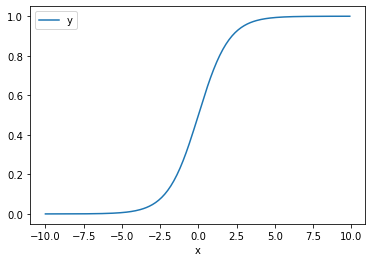

In [2]:
import pandas as pd


pd.DataFrame({
    "x": np.arange(-10, 10, 0.1),
    "y": LogisticClassifier().sigmoid(np.arange(-10, 10, 0.1))
}).plot.line(x="x", y="y")

学習が可能なことを確認します。

In [3]:
def test_train():
    X = np.array([[1.0, 0.0, 0.0], [0.0, 0.1, 0.0], [1.0, 0.0, 0.0]])
    y = np.array([1, 0, 1])
    model = LogisticClassifier().train(X, y, eps=0)
    np.testing.assert_allclose(y, model.predict_proba(X), atol=0.01)

test_train()

### 1.2 データの作成

データを読み込み、ベクトル化するクラスを作成します。

In [4]:
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer


class Converter():
    
    def __init__(self):
        self.vectorizer = None
        self.encoder = None

    def tokenize(self, text):
        return [s.rstrip('.') for s in text.split(' ')]

    def to_dict(self, tokens):
        return Counter(tokens)

    def read_file(self, file_name):
        dataset = []
        with open(file_name) as f:
            for line in f.readlines():
                fields = line.strip('\n').split('\t')
                y = fields[0]
                x = self.to_dict(self.tokenize(fields[1]))
                dataset.append((x, y))
        return dataset
    
    def fit_transform(self, dataset):
        self.vectorizer = DictVectorizer()
        self.encoder = LabelEncoder()
        X = self.vectorizer.fit_transform([d[0] for d in dataset])
        y = self.encoder.fit_transform([d[1] for d in dataset])
        return X, y
    
    def transform(self, dataset):
        X = self.vectorizer.transform([d[0] for d in dataset])
        y = self.encoder.transform([d[1] for d in dataset])
        return X, y        

データを取得します。[5.9. スパムフィルタの構築](https://chokkan.github.io/mlnote/classification/01binary.html#id12)と同じものを使用します。

In [5]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip -f -P data/

wget: invalid option -- 'f'
Usage: wget [OPTION]... [URL]...

Try `wget --help' for more options.


In [6]:
!unzip data/smsspamcollection.zip -f -d data/

Archive:  data/smsspamcollection.zip
caution: filename not matched:  -f


In [7]:
!head data/SMSSpamCollection

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
ham	Ok lar... Joking wif u oni...
spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
ham	U dun say so early hor... U c already then say...
ham	Nah I don't think he goes to usf, he lives around here though
spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
ham	Even my brother is not like to speak with me. They treat me like aids patent.
ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
spam	H

データの中を参照してみます。

In [8]:
converter = Converter()
dataset = converter.read_file("data/SMSSpamCollection")
dataset[10]

(Counter({"I'm": 1,
          'gonna': 1,
          'be': 1,
          'home': 1,
          'soon': 1,
          'and': 1,
          'i': 1,
          "don't": 1,
          'want': 1,
          'to': 1,
          'talk': 1,
          'about': 1,
          'this': 1,
          'stuff': 1,
          'anymore': 1,
          'tonight,': 1,
          'k?': 1,
          "I've": 1,
          'cried': 1,
          'enough': 1,
          'today': 1}),
 'ham')

テストデータと評価データに分離します。

In [9]:
from sklearn.model_selection import train_test_split


train_data, test_data = train_test_split(dataset, test_size=0.1, random_state=0)
len(train_data), len(test_data)

(5016, 558)

学習データをベクトル化します

In [10]:
X, y = converter.fit_transform(train_data)

In [11]:
X.shape

(5016, 13205)

In [12]:
y.shape

(5016,)

学習を実行します。

In [13]:
model = LogisticClassifier().train(X, y, eta=1.0, alpha=1e-6, epoch=100000, eps=1e-6)

## 2. 評価データ上での正解率

評価データを使い、学習したモデルを評価します。

In [14]:
X_test, y_test = converter.transform(test_data)

In [15]:
from sklearn.metrics import classification_report


print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       469
           1       0.90      0.88      0.89        89

    accuracy                           0.96       558
   macro avg       0.94      0.93      0.93       558
weighted avg       0.96      0.96      0.96       558



正解率、`accuracy`は0.96となりました。学習できていることがわかります。

## 3. 学習で求めたパラメータ

In [16]:
weight = pd.Series(model.w.flatten(), index=converter.vectorizer.feature_names_)

重みの絶対値が大きいものトップ20を表示します。

In [17]:
weight.nlargest(20)

let's          7.011402
Txt            6.815124
won            6.270492
FREE           6.203087
txt            6.159097
Luv            6.015718
claim          5.866501
service        5.611788
07090201529    5.553809
Call           5.505962
Ltd            5.358055
Reply          5.114874
STOP           5.099550
&              5.082633
link           5.015280
UK             5.010225
mobile         4.887414
adult          4.606951
content        4.523106
£1.50          4.408982
dtype: float64

重みが負のものトップ20を表示します。

In [18]:
weight.nsmallest(20)

Ok      -6.399188
me      -5.345491
No      -5.110769
Its     -5.099795
he      -5.085205
Then    -5.079515
So      -4.853333
Yup     -4.835432
i       -4.769867
:)      -4.753548
Okie    -4.742343
Happy   -4.690192
later   -4.688453
I       -4.684401
that    -4.576131
What    -4.530021
still   -4.444850
in      -4.372353
–       -4.342440
ü       -4.340403
dtype: float64